## Problem Framing

Flight ticket prices do not fully capture the value a traveler receives.
Two flights with similar fares can differ significantly in travel time, number of stops, and convenience.

This notebook focuses on understanding airline pricing behavior and constructing a Value-for-Money (VFM) score that balances price against time and comfort factors.

Rather than optimizing prediction accuracy, the goal is to derive interpretable insights that help compare airlines, routes, and travel options more meaningfully.

## Dataset Overview

The dataset contains information on domestic Indian flights in 2019, including airline, route, timing, duration, number of stops, and final ticket price.

The target variable is Price, while the remaining features describe operational and temporal aspects of each flight.

Below is a brief structural overview before any transformation or modeling.

In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("/kaggle/input/indian-flight-dataser/IndianFlightdata - Sheet1.csv")

# Basic structure
df.shape, df.head()


((10683, 11),
        Airline Date_of_Journey    Source Destination                  Route  \
 0       IndiGo      24/03/2019  Banglore   New Delhi              BLR → DEL   
 1    Air India       1/05/2019   Kolkata    Banglore  CCU → IXR → BBI → BLR   
 2  Jet Airways       9/06/2019     Delhi      Cochin  DEL → LKO → BOM → COK   
 3       IndiGo      12/05/2019   Kolkata    Banglore        CCU → NAG → BLR   
 4       IndiGo      01/03/2019  Banglore   New Delhi        BLR → NAG → DEL   
 
   Dep_Time  Arrival_Time Duration Total_Stops Additional_Info  Price  
 0    22:20  01:10 22 Mar   2h 50m    non-stop         No info   3897  
 1    05:50         13:15   7h 25m     2 stops         No info   7662  
 2    09:25  04:25 10 Jun      19h     2 stops         No info  13882  
 3    18:05         23:30   5h 25m      1 stop         No info   6218  
 4    16:50         21:35   4h 45m      1 stop         No info  13302  )

In [2]:
import re
#re means regex used to parse texts to make it numeric as split() can't be executed.
"""it is basically pattern matching"""

def duration_to_minutes(duration):
    hours = 0
    minutes = 0
    
    if isinstance(duration, str):
        h_match = re.search(r'(\d+)h', duration)
        m_match = re.search(r'(\d+)m', duration)
        # This means:
        #“If you see digits followed by h, capture the digits”
        #“If you see digits followed by m, capture the digits”
        
        if h_match:
            hours = int(h_match.group(1))
        if m_match:
            minutes = int(m_match.group(1))
    
    return hours * 60 + minutes

df['Duration_minutes'] = df['Duration'].apply(duration_to_minutes)

df[['Duration', 'Duration_minutes']].head()


,Duration,Duration_minutes
0,2h 50m,170
1,7h 25m,445
2,19h,1140
3,5h 25m,325
4,4h 45m,285


In [3]:
import re

def parse_stops(stops):
    if isinstance(stops, str):
        if stops.lower() == 'non-stop':
            return 0
        #This sets a baseline:
         #zero stops = zero inconvenience
        
        match = re.search(r'(\d+)', stops)
        if match:
            return int(match.group(1))
    
    return None

df['Stops_numeric'] = df['Total_Stops'].apply(parse_stops)

df[['Total_Stops', 'Stops_numeric']].head()


,Total_Stops,Stops_numeric
0,non-stop,0.0
1,2 stops,2.0
2,2 stops,2.0
3,1 stop,1.0
4,1 stop,1.0


In [4]:
df[['Duration_minutes', 'Stops_numeric']].describe()


,Duration_minutes,Stops_numeric
count,10683.000000,10682.000000
mean,643.093232,0.824190
std,507.862001,0.675229
min,5.000000,0.000000
25%,170.000000,0.000000
50%,520.000000,1.000000
75%,930.000000,1.000000
max,2860.000000,4.000000


In [5]:
df['Stops_numeric'].value_counts().sort_index()


Stops_numeric
0.0    3491
1.0    5625
2.0    1520
3.0      45
4.0       1
Name: count, dtype: int64

## Value-for-Money (VFM) Score

### Constructing a Value-for-Money (VFM) Score

- To compare flights beyond raw price, a Value-for-Money score is defined by penalizing ticket price based on travel duration and number of stops.
- The objective is not to find a perfect formula, but a transparent and interpretable metric that aligns with common traveler preferences.

In [6]:
# Normalize duration to reduce scale effects
df['Duration_norm'] = df['Duration_minutes'] / df['Duration_minutes'].mean()

# Penalty weights (kept simple and interpretable)
ALPHA = 0.25   # penalty per stop
BETA = 0.30    # penalty for longer duration

# Adjusted cost captures inconvenience
df['Adjusted_Cost'] = df['Price'] * (
    1 + ALPHA * df['Stops_numeric'] + BETA * df['Duration_norm']
)

# Value-for-Money score (higher = better)
df['VFM_Score'] = 1 / df['Adjusted_Cost']

df[['Price', 'Duration_minutes', 'Stops_numeric', 'Adjusted_Cost', 'VFM_Score']].head()


,Price,Duration_minutes,Stops_numeric,Adjusted_Cost,VFM_Score
0,3897,170,0.0,4206.048502,0.000238
1,7662,445,2.0,13083.557867,0.000076
2,13882,1140,2.0,28205.512771,0.000035
3,6218,325,1.0,8715.217120,0.000115
4,13302,285,1.0,18396.016512,0.000054


In [7]:
df[['Duration_minutes', 'Stops_numeric']].isna().sum()


Duration_minutes    0
Stops_numeric       1
dtype: int64

In [8]:
df[df['Stops_numeric'].isna()][['Total_Stops']]


,Total_Stops
9039,NaN


In [9]:
reg_df = df[['Duration_minutes', 'Stops_numeric', 'Price']].dropna()

reg_df.shape


(10682, 3)

## Where Do α and β Come From?

### Grounding Penalty Weights from Data

The penalty weights used in the VFM score represent traveler preferences toward stops and travel time.
To ground these values, we estimate how market prices vary with duration and number of stops using a simple linear model.

The resulting coefficients provide reference magnitudes, not exact values.

In [10]:
from sklearn import linear_model
#here we are using linear regression model to estimate duration and stops coefficient, 
#which eventually will lead us to alpha and beta.
#that's because these coefficients represent the average change in the target variable for a one-unit change in a feature, 
#holding all other features constant.

X = reg_df[['Duration_minutes', 'Stops_numeric']] # factors causing price 
y = reg_df['Price'] # price itself 

lin_reg = linear_model.LinearRegression()
lin_reg.fit(X, y)

coef_duration = lin_reg.coef_[0]
coef_stops = lin_reg.coef_[1]

"""coef_duration → ₹ change per extra minute"""
"""coef_stops → ₹ change per extra stop"""
coef_duration, coef_stops

(np.float64(1.211998710566567), np.float64(3451.6084859529387))

In [11]:
avg_price = df['Price'].mean()
avg_duration = df['Duration_minutes'].mean()

alpha_ref = coef_stops / avg_price
beta_ref = (coef_duration * avg_duration) / avg_price

"""alpha_ref = coef_stops / avg_price"""
"""beta_ref = (coef_duration * avg_duration) / avg_price"""

alpha_ref, beta_ref


(np.float64(0.37983758452209365), np.float64(0.08577337607674006))

Now α and β are:

- Data-backed

- Interpretable

- Defensible

## Airline Strategy Profiling
Using the Value-for-Money score, airlines are profiled based on how they price convenience and time.
Rather than focusing on individual flights, we aggregate behavior at the airline level to identify systematic pricing strategies.

In [12]:
df.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price', 'Duration_minutes', 'Stops_numeric',
       'Duration_norm', 'Adjusted_Cost', 'VFM_Score'],
      dtype='object')

In [13]:
airline_profile = (
    df.groupby('Airline')
      .agg(
          avg_price=('Price', 'mean'),
          avg_duration=('Duration_minutes', 'mean'),
          avg_stops=('Stops_numeric', 'mean'),
          avg_vfm=('VFM_Score', 'mean'),
          price_std=('Price', 'std')
      )
      .sort_values('avg_vfm', ascending=False)
)
"""It Collapses thousands of flights into different profiles of airlines."""
airline_profile


,avg_price,avg_duration,avg_stops,avg_vfm,price_std
Airline,,,,,
SpiceJet,4338.284841,178.484108,0.180929,0.000242,1849.922514
Trujet,4140.000000,195.000000,1.000000,0.000180,NaN
IndiGo,5673.682903,285.406722,0.404774,0.000171,2264.142168
Air Asia,5590.260188,348.275862,0.460815,0.000166,2027.362290
GoAir,5861.056701,298.969072,0.525773,0.000161,2703.585767
Vistara,7796.348643,598.413361,0.448852,0.000118,2914.298578
Vistara Premium economy,8962.333333,153.333333,0.000000,0.000112,2915.405518
Air India,9611.210616,943.253425,1.237579,0.000088,3900.952942
Jet Airways,11643.923357,849.733697,1.017667,0.000069,4258.940578


In [14]:
airline_profile['price_std'] = airline_profile['price_std'].fillna(0)


In [15]:
from sklearn.preprocessing import StandardScaler

scaled = airline_profile[['avg_price', 'avg_duration', 'avg_stops', 'price_std']]
scaler = StandardScaler()
scaled_values = scaler.fit_transform(scaled)

"""so now, each feature contributes fairly."""

scaled_df = pd.DataFrame(
    scaled_values,
    index=airline_profile.index,
    columns=scaled.columns
)

scaled_df['avg_vfm'] = airline_profile['avg_vfm']
scaled_df


,avg_price,avg_duration,avg_stops,price_std,avg_vfm
Airline,,,,,
SpiceJet,-0.540968,-1.094046,-1.297159,-0.538935,0.000242
Trujet,-0.554923,-1.028894,0.667973,-1.213277,0.000180
IndiGo,-0.446984,-0.672254,-0.760107,-0.387942,0.000171
Air Asia,-0.452855,-0.424245,-0.625651,-0.474254,0.000166
GoAir,-0.433797,-0.618753,-0.469802,-0.227754,0.000161
Vistara,-0.297593,0.562506,-0.654354,-0.150944,0.000118
Vistara Premium economy,-0.215532,-1.193262,-1.731248,-0.150540,0.000112
Air India,-0.169864,1.922844,1.237976,0.208716,0.000088
Jet Airways,-0.026804,1.553924,0.710359,0.339211,0.000069


In [16]:
from sklearn.cluster import KMeans
#clustering used here to discover natural strategy groups
#because No labels=no bias.

kmeans = KMeans(n_clusters=3, random_state=42)
airline_profile['strategy_cluster'] = kmeans.fit_predict(scaled_values)

#here as we can observe that price,duration,stops are on different scales.
#and as kmeans uses distance, so the scale matters a lot.

airline_profile.sort_values('strategy_cluster')

cluster_map = {
    0: 'Value-Oriented',
    1: 'Ultra-Premium',
    2: 'Convenience-Premium'
}

airline_profile['strategy_label'] = airline_profile['strategy_cluster'].map(cluster_map)
airline_profile
#Airlines with similar behavior get same cluster

,avg_price,avg_duration,avg_stops,avg_vfm,price_std,strategy_cluster,strategy_label
Airline,,,,,,,
SpiceJet,4338.284841,178.484108,0.180929,0.000242,1849.922514,0,Value-Oriented
Trujet,4140.000000,195.000000,1.000000,0.000180,0.000000,0,Value-Oriented
IndiGo,5673.682903,285.406722,0.404774,0.000171,2264.142168,0,Value-Oriented
Air Asia,5590.260188,348.275862,0.460815,0.000166,2027.362290,0,Value-Oriented
GoAir,5861.056701,298.969072,0.525773,0.000161,2703.585767,0,Value-Oriented
Vistara,7796.348643,598.413361,0.448852,0.000118,2914.298578,2,Convenience-Premium
Vistara Premium economy,8962.333333,153.333333,0.000000,0.000112,2915.405518,0,Value-Oriented
Air India,9611.210616,943.253425,1.237579,0.000088,3900.952942,2,Convenience-Premium
Jet Airways,11643.923357,849.733697,1.017667,0.000069,4258.940578,2,Convenience-Premium


## Visualizing Airline Strategy Clusters

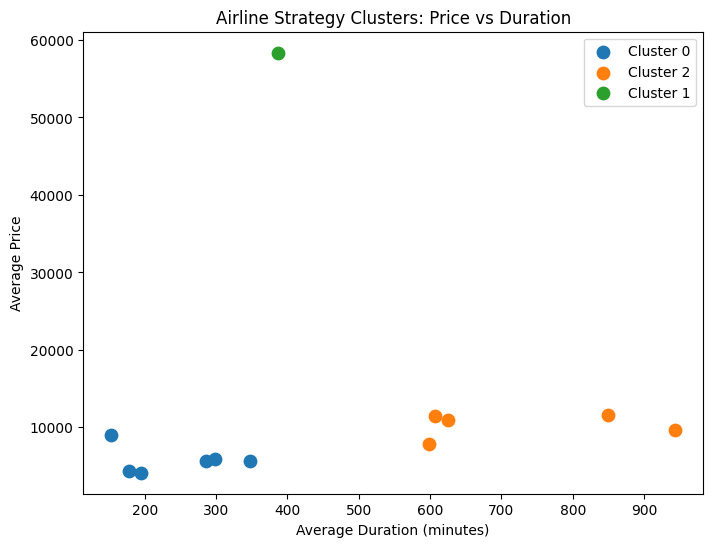

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for cluster in airline_profile['strategy_cluster'].unique():
    subset = airline_profile[airline_profile['strategy_cluster'] == cluster]
    plt.scatter(
        subset['avg_duration'],
        subset['avg_price'],
        label=f'Cluster {cluster}',
        s=80
    )

plt.xlabel('Average Duration (minutes)')
plt.ylabel('Average Price')
plt.title('Airline Strategy Clusters: Price vs Duration')
plt.legend()
plt.show()


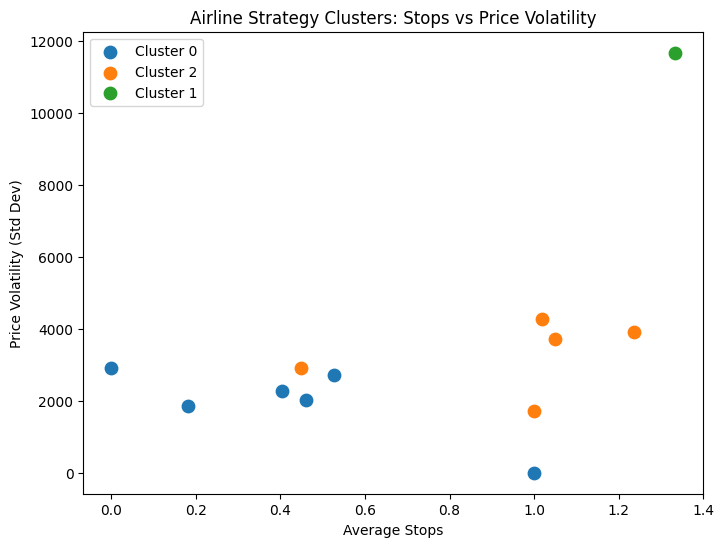

In [18]:
plt.figure(figsize=(8, 6))

for cluster in airline_profile['strategy_cluster'].unique():
    subset = airline_profile[airline_profile['strategy_cluster'] == cluster]
    plt.scatter(
        subset['avg_stops'],
        subset['price_std'],
        label=f'Cluster {cluster}',
        s=80
    )

plt.xlabel('Average Stops')
plt.ylabel('Price Volatility (Std Dev)')
plt.title('Airline Strategy Clusters: Stops vs Price Volatility')
plt.legend()
plt.show()


- **These scatter plots are used for the purpose of validating clustering and make strategies viusually obvious.**

### Points Observed
- **Stops hurt more than time.**
- **Budget airlines usually deliver better value.**
- **Premium airlines sell convenience at a high markup.**
- **Some airlines are far less predictable on pricing.**
- **The cheapest ticket isn’t always the best deal.**

## Persona-Based VFM (Budget vs Business Traveler)

### Traveler Personas and Preference Sensitivity

Different travelers place different importance on time, cost, and convenience.
To reflect this, the Value-for-Money score is recalculated for two representative personas.

In [19]:
# Define traveler personas
personas = {
    'Budget_Traveler': {'alpha': 0.20, 'beta': 0.10},
    'Business_Traveler': {'alpha': 0.50, 'beta': 0.30}
}

for persona, params in personas.items():
    adjusted_cost = df['Price'] * (
        1 + params['alpha'] * df['Stops_numeric'] + params['beta'] * df['Duration_norm']
    )
    df[f'VFM_{persona}'] = 1 / adjusted_cost

"""α and β now depend on the traveler, not the dataset."""

df[[col for col in df.columns if 'VFM_' in col]].head()


,VFM_Score,VFM_Budget_Traveler,VFM_Business_Traveler
0,0.000238,0.000250,0.000238
1,0.000076,0.000089,0.000059
2,0.000035,0.000046,0.000028
3,0.000115,0.000129,0.000097
4,0.000054,0.000060,0.000046


#### Considering that,
- Budget travelers prioritize lower prices and tolerate inconvenience, 
- Business travelers penalize both stops and longer durations more aggressively.

In [20]:
df.groupby('Airline')[[f'VFM_{p}' for p in personas]].mean().sort_values(
    'VFM_Budget_Traveler', ascending=False
)


,VFM_Budget_Traveler,VFM_Business_Traveler
Airline,,
SpiceJet,0.000254,0.000239
Trujet,0.000196,0.000152
IndiGo,0.000183,0.000165
Air Asia,0.000179,0.000160
GoAir,0.000175,0.000153
Vistara,0.000131,0.000115
Vistara Premium economy,0.000118,0.000112
Air India,0.000101,0.000081
Jet Airways,0.000080,0.000063


#### The above cell answers:

- Which airlines are best for budget travelers?
- Which airlines collapse for business travelers?
- Who performs well for both?

### This whole section shows us that,

- Value is subjective.
- Rankings depend on preferences.
- Airlines don’t have one universal “best” strategy.

## Route-Level Airline Strategy (Same Airline ≠ Same Behavior)

### Route-Level Strategy Differences

Airline pricing behavior is not uniform across routes.
To examine this, Value-for-Money scores are analyzed at the Airline × Route level.

In [21]:
route_profile = (
    df.groupby(['Airline', 'Source', 'Destination'])
      .agg(
          avg_price=('Price', 'mean'),
          avg_duration=('Duration_minutes', 'mean'),
          avg_stops=('Stops_numeric', 'mean'),
          avg_vfm=('VFM_Score', 'mean')
      )
      .reset_index()
)

route_profile.sort_values('avg_vfm', ascending=False).head(10)


,Airline,Source,Destination,avg_price,avg_duration,avg_stops,avg_vfm
34,SpiceJet,Mumbai,Hyderabad,2511.106557,91.557377,0.008197,0.000434
19,IndiGo,Mumbai,Hyderabad,3659.816327,91.352041,0.005102,0.000302
31,SpiceJet,Chennai,Kolkata,3993.523438,138.632812,0.000000,0.000246
9,Air India,Mumbai,Hyderabad,6260.051471,356.764706,0.477941,0.000236
29,SpiceJet,Banglore,Delhi,4012.839416,168.284672,0.000000,0.000235
10,GoAir,Banglore,Delhi,4050.289855,170.072464,0.000000,0.000234
0,Air Asia,Banglore,Delhi,4265.577465,168.380282,0.000000,0.000228
16,IndiGo,Chennai,Kolkata,4538.766304,141.548913,0.000000,0.000220
14,IndiGo,Banglore,Delhi,4399.581967,171.748634,0.000000,0.000213
33,SpiceJet,Kolkata,Banglore,4642.883333,190.683333,0.173333,0.000211


Some airlines offer strong value on specific routes while charging a premium on others, indicating route-specific pricing strategies rather than a single airline-wide policy.

## When Should You Book? (Client-Facing Intelligence)

### Timing Effects: When Do Flights Offer Better Value?

Flight prices often vary by travel date and weekday.
This section explores temporal patterns to identify potential booking advantages.

In [22]:
# Extract weekday
df['Journey_Date'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y')
df['Weekday'] = df['Journey_Date'].dt.day_name()

df.groupby('Weekday')['Price'].mean().sort_values()


Weekday
Monday       8499.530811
Thursday     8931.379367
Saturday     8972.905389
Tuesday      9026.149597
Wednesday    9277.514190
Sunday       9525.508820
Friday       9717.996700
Name: Price, dtype: float64

In [23]:
df.groupby('Weekday')['VFM_Score'].mean().sort_values(ascending=False)


Weekday
Friday       0.000134
Monday       0.000119
Tuesday      0.000113
Saturday     0.000110
Wednesday    0.000107
Sunday       0.000104
Thursday     0.000103
Name: VFM_Score, dtype: float64

- **Temporal effects exist but are secondary to airline strategy and route structure.**
- **It suggests that what you book matters more than when you book.**
